# NIST Pedestrian and Face Detection

Pedestrian and Face Detection uses OpenCV to identify people standing in a picture or a video and NIST use case in this document is built with Apache Spark and Mesos clusters on multiple compute nodes.

The example in this tutorial deploys software packages on OpenStack using Ansible with its roles.

Original                             | Pedestrian Detected
:-----------------------------------:|:------------------------------------------------------:
![alt baby](https://raw.githubusercontent.com/lee212/classes/master/spring-2017/source/notebooks/files/image03.png 'baby')|![alt baby-detected](https://raw.githubusercontent.com/lee212/classes/master/spring-2017/source/notebooks/files/image05.png 'baby-detected')

Original                                 | Pedestrian and Face/eyes Detected
:---------------------------------------:|:----------------------------------------------------------:
![alt person](https://raw.githubusercontent.com/lee212/classes/master/spring-2017/source/notebooks/files/image06.png 'person')|![alt person-detected](https://raw.githubusercontent.com/lee212/classes/master/spring-2017/source/notebooks/files/image04.png 'person-detected')

## Introduction

Human (pedestrian) detection and face detection have been studied during the last several years and models for them have improved along with Histograms of Oriented Gradients (HOG) for Human Detection [1]. OpenCV is a Computer Vision library including the SVM classifier and the HOG object detector for pedestrian detection and INRIA Person Dataset [2] is one of popular samples for both training and testing purposes. In this document, we deploy Apache Spark on Mesos clusters to train and apply detection models from OpenCV using Python API.

### INRIA Person Dataset

This dataset contains positive and negative images for training and test purposes with annotation files for upright persons in each image. 288 positive test images, 453 negative test images, 614 positive training images and 1218 negative training images are included along with normalized 64x128 pixel formats. 970MB dataset is available to download [3].

### HOG with SVM model

Histogram of Oriented Gradient (HOG) and Support Vector Machine (SVM) are used as object detectors and classifiers and built-in python libraries from OpenCV provide these models for human detection.

### Ansible Automation Tool

Ansible is a python tool to install/configure/manage software on multiple machines with JSON files where system descriptions are defined. There are reasons why we use Ansible:

- Expandable: Leverages Python (default) but modules can be written in any language
- Agentless: no setup required on managed node
- Security: Allows deployment from user space; uses ssh for authentication
- Flexibility: only requires ssh access to privileged user
- Transparency: YAML Based script files express the steps of installing and configuring software
- Modularity: Single Ansible Role (should) contain all required commands and variables to deploy software package independently
- Sharing and portability: roles are available from source (github, bitbucket, gitlab, etc) or the Ansible Galaxy portal

We use Ansible roles to install software packages for Humand and Face Detection which requires to run OpenCV Python libraries on Apache Mesos with a cluster configuration. Dataset is also downloaded from the web using an ansible role.


## Deployment by Ansible

Ansible is to deploy applications and build clusters for batch-processing large datasets towards target machines e.g. VM instances on OpenStack and we use ansible roles with *include* directive to organize layers of big data software stacks (BDSS). Ansible provides abstractions by Playbook Roles and reusability by Include statements. We define X application in X Ansible Role, for example, and use include statements to combine with other applications e.g. Y or Z. The layers exist in sub directories (see below) to add modularity to your Ansible deployment. For example, there are five roles used in this example that are Apache Mesos in a scheduler layer, Apache Spark in a processing layer, a OpenCV library in an application layer, INRIA Person Dataset in a dataset layer and a python script for human and face detection in an analytics layer. If you have an additional software package to add, you can simply add a new role in a main ansible playbook with *include* directive. With this, your Ansible playbook maintains simple but flexible to add more roles without having a large single file which is getting difficult to read when it deploys more applications on multiple layers. The main Ansible playbook runs Ansible roles in order which look like:

```
---
include: sched/00-mesos.yml
include: proc/01-spark.yml
include: apps/02-opencv.yml
include: data/03-inria-dataset.yml
Include: anlys/04-human-face-detection.yml
```

Directory names e.g. sched, proc, data, or anlys indicate BDSS layers like:
- sched: scheduler layer
- proc: data processing layer
- apps: application layer
- data: dataset layer
- anlys: analytics layer
and two digits in the filename indicate an order of roles to be run. 

## Cloudmesh for Provisioning

It is assumed that virtual machines are created by cloudmesh, the cloud management software. For example on OpenStack, 

```cm cluster create -N=6```

command starts a set of virtual machine instances. The number of machines and groups for clusters e.g. namenodes and datanodes are defined in the Ansible inventory file, a list of target machines with groups, which will be generated once machines are ready to use by cloudmesh. Ansible roles install software and dataset on virtual clusters after that stage.

## Roles Explained for Installation

Mesos role is installed first as a scheduler layer for masters and slaves where mesos-master runs on the masters group and mesos-slave runs on the slaves group. Apache Zookeeper is included in the mesos role therefore mesos slaves find an elected mesos leader for the coordination. Spark, as a data processing layer, provides two options for distributed job processing, batch job processing via a cluster mode and real-time processing via a client mode. The Mesos dispatcher runs on a masters group to accept a batch job submission and Spark interactive shell, which is the client mode, provides real-time processing on any node in the cluster. Either way, Spark is installed later to detect a master (leader) host for a job submission. Other roles for OpenCV, INRIA Person Dataset and Human and Face Detection Python applications are followed by.

The following software are expected in the stacks according to the [github](https://github.com/futuresystems/pedestrian-and-face-detection):

- mesos cluster (master, worker)
- spark (with dispatcher for mesos cluster mode)
- openCV
- zookeeper
- INRIA Person Dataset
- Detection Analytics in Python

- [1] Dalal, Navneet, and Bill Triggs. "Histograms of oriented gradients for human detection." 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05). Vol. 1. IEEE, 2005. [pdf]
- [2] http://pascal.inrialpes.fr/data/human/
- [3] ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
- [4] https://docs.python.org/2/library/configparser.html

### Server groups for Masters/Slaves by Ansible inventory

We may separate compute nodes in two groups: masters and workers therefore Mesos masters and zookeeper quorums manage job requests and leaders and workers run actual tasks. Ansible needs group definitions in their inventory therefore software installation associated with a proper part can be completed. 

Example of Ansible Inventory file (inventory.txt)

```
[masters]
10.0.5.67
10.0.5.68
10.0.5.69
[slaves]
10.0.5.70
10.0.5.71
10.0.5.72


```

## Instructions for Deployment

The following commands complete NIST Pedestrian and Face Detection deployment on OpenStack.

### Cloning Pedestrian Detection Repository from Github

Roles are included as submodules which require ``--recursive`` option to checkout them all.

In [2]:
!git clone --recursive https://github.com/futuresystems/pedestrian-and-face-detection.git

Cloning into 'pedestrian-and-face-detection'...
remote: Counting objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.
Checking connectivity... done.
Submodule 'roles/ansible-role-analytics' (https://github.com/futuresystems/ansible-role-analytics.git) registered for path 'roles/ansible-role-analytics'
Submodule 'roles/ansible-role-dataset' (https://github.com/futuresystems/ansible-role-dataset.git) registered for path 'roles/ansible-role-dataset'
Submodule 'roles/ansible-role-mesos-by-mesosphere' (https://github.com/lee212/ansible-role-mesos-by-mesosphere.git) registered for path 'roles/ansible-role-mesos-by-mesosphere'
Submodule 'roles/ansible-role-opencv' (https://github.com/futuresystems/ansible-role-opencv) registered for path 'roles/ansible-role-opencv'
Submodule 'roles/ansible-role-spark-for-mesos' (https://github.com/lee212/ansible-role-spark-for-mesos.git) registered for path 'roles/ansible-role-spark-for-mesos

Change the following variable with actual ip addresses:

In [3]:
sample_inventory="""[masters]
10.0.5.67
10.0.5.68
10.0.5.69
[slaves]
10.0.5.70
10.0.5.71
10.0.5.72"""

Create a ``inventory.txt`` file with the variable in your local directory.

In [4]:
!printf "$sample_inventory" > inventory.txt
!cat inventory.txt

[masters]
10.0.5.67
10.0.5.68
10.0.5.69
[slaves]
10.0.5.70
10.0.5.71
10.0.5.72

Add ``ansible.cfg`` file with options for ssh host key checking and login name.

In [5]:
ansible_config="""[defaults]
host_key_checking=false
remote_user=ubuntu"""
!printf "$ansible_config" > ansible.cfg
!cat ansible.cfg

[defaults]
host_key_checking=false
remote_user=ubuntu

Check accessibility by ansible ping like:

In [8]:
!ansible -m ping -i inventory.txt all

10.0.5.70 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
10.0.5.71 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
10.0.5.68 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
10.0.5.69 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
10.0.5.67 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
10.0.5.72 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}


Make sure that you have a correct ssh key in your account otherwise you may encounter 'FAILURE' in the ping test above.

### Ansible Playbook

We use a main ansible playbook to deploy software packages for NIST Pedestrian and Face detection which includes:
- mesos
- spark
- zookeeper
- opencv
- INRIA Person dataset
- Python script for the detection

In [19]:
!cd pedestrian-and-face-detection/ && ansible-playbook -i ../inventory.txt site.yml


PLAY [mesos base] **************************************************************

TASK [setup] *******************************************************************
ok: [10.0.5.70]
ok: [10.0.5.69]
ok: [10.0.5.68]
ok: [10.0.5.71]
ok: [10.0.5.67]
ok: [10.0.5.72]

TASK [ansible-role-mesos-by-mesosphere : include_vars] *************************
ok: [10.0.5.67]
ok: [10.0.5.68]
ok: [10.0.5.69]
ok: [10.0.5.70]
ok: [10.0.5.71]
ok: [10.0.5.72]

TASK [ansible-role-mesos-by-mesosphere : Add apt-key] **************************
changed: [10.0.5.70]
changed: [10.0.5.71]
changed: [10.0.5.69]
changed: [10.0.5.68]
changed: [10.0.5.67]
changed: [10.0.5.72]

TASK [ansible-role-mesos-by-mesosphere : Remove mesosphere repo] ***************
ok: [10.0.5.68]
ok: [10.0.5.71]
ok: [10.0.5.69]
ok: [10.0.5.70]
ok: [10.0.5.67]
ok: [10.0.5.72]

TASK [ansible-role-mesos-by-mesosphere : Add mesosphere repo] ******************
changed: [10.0.5.71]
changed: [10.0.5.69]
changed: [10.0.5.70]
changed: [10.0.5.67]
changed: [

The installation may take 30 minutes or an hour to complete.

## OpenCV in Python

Before we run our code for this project, let's try OpenCV first to see how it works.

### Import cv2

Let's import opencv python module and we will use images from the online database image-net.org to test OpenCV image recognition.

In [2]:
import cv2

Let's download a mailbox image with a red color to see if opencv identifies the shape with a color. The example file in this tutorial is:

In [3]:
!curl http://farm1.static.flickr.com/147/354889056_3bc5f6fa28.jpg > mailbox.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   681k      0 --:--:-- --:--:-- --:--:--  681k


In [98]:
!curl http://farm4.static.flickr.com/3061/2739199963_ee78af76ef.jpg > mailbox.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  167k  100  167k    0     0   686k      0 --:--:-- --:--:-- --:--:--  684k


In [3]:
%matplotlib inline

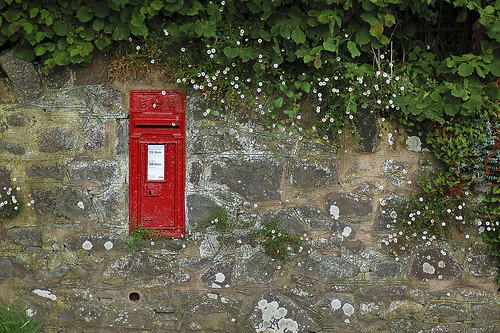

In [58]:
from IPython.display import Image
mailbox_image = "mailbox.jpg"
Image(filename=mailbox_image)

You can try other images. Check out the image-net.org for mailbox images: http://image-net.org/synset?wnid=n03710193

### Image Detection
Just for a test, let's try to detect a red color shaped mailbox using opencv python functions.

There are key functions that we use:
* cvtColor: to convert a color space of an image
* inRange: to detect a mailbox based on the range of red color pixel values
* np.array: to define the range of red color using a Numpy library for better calculation
* findContours: to find a outline of the object
* bitwise_and: to black-out the area of contours found

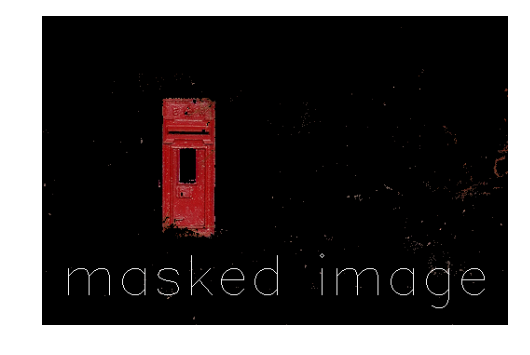

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# imread for loading an image
img = cv2.imread(mailbox_image)
# cvtColor for color conversion
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

# define range of red color in hsv
lower_red1 = np.array([0, 50, 50])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 50, 50])
upper_red2 = np.array([180, 255, 255])

# threshold the hsv image to get only red colors
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = mask1 + mask2

# find a red color mailbox from the image
im2, contours,hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# bitwise_and to remove other areas in the image except the detected object
res = cv2.bitwise_and(img, img, mask = mask)

# turn off - x, y axis bar
plt.axis("off")
# text for the masked image
cv2.putText(res, "masked image", (20,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
# display
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

The red color mailbox is left alone in the image which we wanted to find in this example by opencv functions. You can try other images with different colors to detect the different shape of objects using findContours and inRange from opencv.

For more information, see the useful links below.

- contours features: http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
- contours: http://docs.opencv.org/3.1.0/d4/d73/tutorial_py_contours_begin.html
- red color in hsv: http://stackoverflow.com/questions/30331944/finding-red-color-using-python-opencv
- inrange: http://docs.opencv.org/master/da/d97/tutorial_threshold_inRange.html
- inrange: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
- numpy: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

## Human and Face Detection in OpenCV

### INRIA Person Dataset

We use INRIA Person dataset to detect upright people and faces in images in this example. Let's download it first.

In [71]:
!curl ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar > INRIAPerson.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  969M  100  969M    0     0  8480k      0  0:01:57  0:01:57 --:--:-- 12.4M


In [73]:
!tar xvf INRIAPerson.tar

INRIAPerson/
INRIAPerson/70X134H96/
INRIAPerson/70X134H96/Test/
INRIAPerson/70X134H96/Test/pos/
INRIAPerson/70X134H96/Test/pos/crop_000001a.png
INRIAPerson/70X134H96/Test/pos/crop_000001b.png
INRIAPerson/70X134H96/Test/pos/crop_000002a.png
INRIAPerson/70X134H96/Test/pos/crop_000002b.png
INRIAPerson/70X134H96/Test/pos/crop_000003a.png
INRIAPerson/70X134H96/Test/pos/crop_000003b.png
INRIAPerson/70X134H96/Test/pos/crop_000004a.png
INRIAPerson/70X134H96/Test/pos/crop_000004b.png
INRIAPerson/70X134H96/Test/pos/crop_000005a.png
INRIAPerson/70X134H96/Test/pos/crop_000005b.png
INRIAPerson/70X134H96/Test/pos/crop_000005c.png
INRIAPerson/70X134H96/Test/pos/crop_000005d.png
INRIAPerson/70X134H96/Test/pos/crop_000006a.png
INRIAPerson/70X134H96/Test/pos/crop_000006b.png
INRIAPerson/70X134H96/Test/pos/crop_000007a.png
INRIAPerson/70X134H96/Test/pos/crop_000007b.png
INRIAPerson/70X134H96/Test/pos/crop_000008a.png
INRIAPerson/70X134H96/Test/pos/crop_000008b.png
INRIAPerson/70X134H96/Test/pos/crop_0000

### Face Detection using Haar Cascades

This section is prepared based on the opencv-python tutorial: http://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html#gsc.tab=0

There is a pre-trained classifier for face detection, download from here:

In [75]:
!curl https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml > haarcascade_frontalface_default.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  908k  100  908k    0     0  2225k      0 --:--:-- --:--:-- --:--:-- 2259k


## Processing by Apache Spark

INRIA Person dataset provides 100+ images and Spark can be used for image processing in parallel.
We load 288 images from "Test/pos" directory.